In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')


In [238]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [239]:
img_size = 512

loader = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

def img_loader(img_name) -> torch.Tensor:
    img = Image.open(img_name)
    img = loader(img).unsqueeze(0)

    return img.to(device, torch.float)

content_img = img_loader('./data/dancing.jpg')
style_img = img_loader('./data/picasso.jpg')

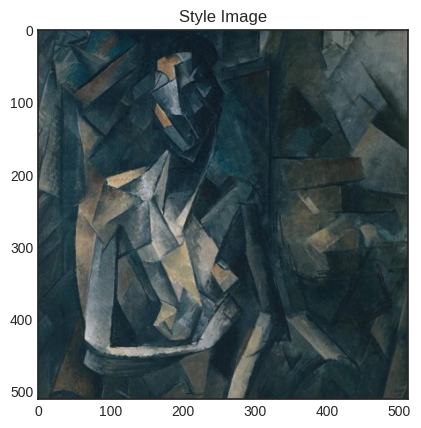

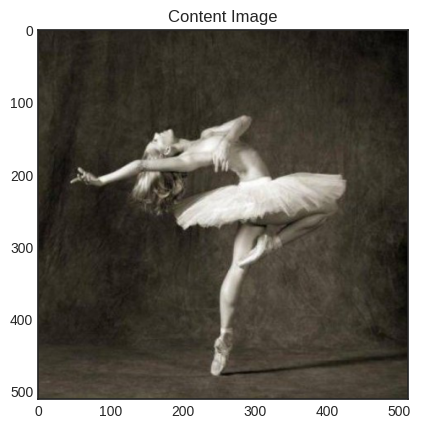

In [240]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor: torch.Tensor, title: str=None):
    img = tensor.cpu().clone()
    img = img.squeeze(0)
    img = unloader(img)

    plt.imshow(img)

    if title:
        plt.title(title)
    
    plt.pause(1e-3)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [241]:
class ContentLoss(nn.Module):
    
    def __init__(self, target: torch.Tensor):
        super().__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)

        return input

In [242]:
def gram_matrix(input: torch.Tensor):
    B, D, H, W = input.size() # B: Batch_size = 1, D: # of feature maps
    features = input.view(B * D, H * W)
    
    G = torch.mm(features, features.T)
    
    return G / (B * D * H * W) # Normalize

In [243]:
class StyleLoss(nn.Module):
    
    def __init__(self, target_features):
        super().__init__()
        self.target = gram_matrix(target_features).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)

        return input

In [244]:
cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.eval()

In [245]:
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [246]:
cnn_norm_mean = torch.tensor([.485, .456, .406])
cnn_norm_std = torch.tensor([.229, .224, .225])

class Normalization(nn.Module):
    def __init__(self, mean: torch.Tensor, std:torch.Tensor):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std # Normalize

In [247]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn: nn.Module, norm_mean, norm_std, content_img, style_img, content_layers=content_layers_default, style_layers=style_layers_default):
    normalization = Normalization(norm_mean, norm_std)

    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU()
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized Layer: {layer.__class__.__name__}')
        
        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target_features = model(style_img).detach()
            style_loss = StyleLoss(target_features)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)
        
    for loc in range(len(model) - 1, -1, -1):
        if isinstance(model[loc], (ContentLoss, StyleLoss)):
            break
        
    model = model[:(loc + 1)]

    return model, content_losses, style_losses
            

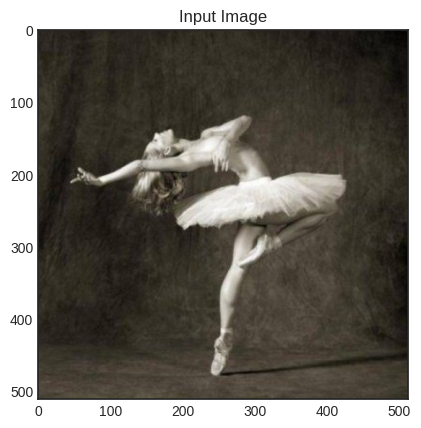

In [248]:
input = content_img.clone()

plt.figure()
imshow(input, 'Input Image')

In [249]:
def get_input_optimizer(input):
    optimizer = optim.LBFGS([input])
    
    return optimizer

In [250]:
def run_style_transfer(cnn: torch.Tensor, norm_mean: torch.Tensor, norm_std: torch.Tensor, content_img: torch.Tensor, style_img: torch.Tensor, input: torch.Tensor, num_steps=300, style_weight=1_000_000, content_weight=1):
    print('Building the style transfer model..')
    
    model, content_losses, style_losses = get_style_model_and_losses(cnn, norm_mean, norm_std, content_img, style_img)
    
    input.requires_grad_()
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input)
    
    print('Optimizing..')
    
    run = [0]
    while run[0] <= num_steps:
        def closure():
            with torch.no_grad():
                input.clamp_(0, 1)

            optimizer.zero_grad()
            model(input)
            
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss
            
            content_score *= content_weight
            style_score *= style_weight

            loss = content_score + style_score
            loss.backward()
            
            run[0] += 1
            
            if run[0] % 50 == 0:
                print(f'run: {run}')
                print(f'Style Loss: {style_score:.4f}, Content Loss: {content_score:.4f}')
                print()

            return content_score + style_score
    
        optimizer.step(closure)

    with torch.no_grad():
        input.clamp_(0, 1)

    return input

Building the style transfer model..
Optimizing..
run: [50]
Style Loss: 3.9354, Content Loss: 4.1631

run: [100]
Style Loss: 1.1117, Content Loss: 3.0175

run: [150]
Style Loss: 0.7160, Content Loss: 2.6611

run: [200]
Style Loss: 0.4753, Content Loss: 2.4990

run: [250]
Style Loss: 0.3419, Content Loss: 2.4117

run: [300]
Style Loss: 0.2595, Content Loss: 2.3567

run: [350]
Style Loss: 0.2097, Content Loss: 2.3222

run: [400]
Style Loss: 0.1802, Content Loss: 2.2952

run: [450]
Style Loss: 0.1637, Content Loss: 2.2745

run: [500]
Style Loss: 0.1552, Content Loss: 2.2602

run: [550]
Style Loss: 0.1488, Content Loss: 2.2482

run: [600]
Style Loss: 0.1446, Content Loss: 2.2394

run: [650]
Style Loss: 0.1423, Content Loss: 2.2319

run: [700]
Style Loss: 0.1400, Content Loss: 2.2259

run: [750]
Style Loss: 0.1388, Content Loss: 2.2216

run: [800]
Style Loss: 0.1373, Content Loss: 2.2177

run: [850]
Style Loss: 0.1361, Content Loss: 2.2143

run: [900]
Style Loss: 0.1353, Content Loss: 2.2117

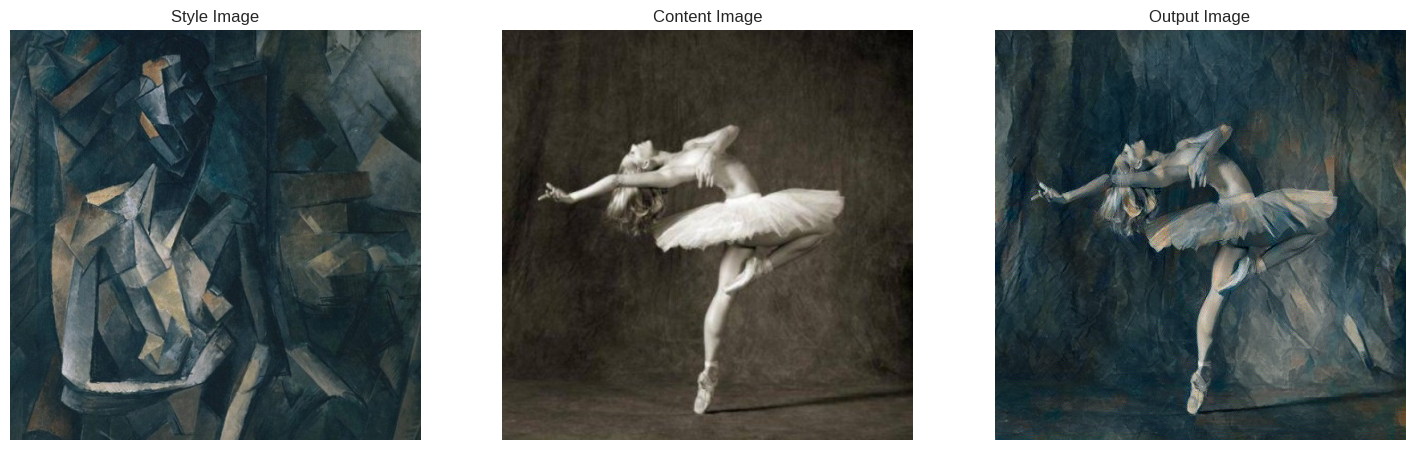

In [251]:
output = run_style_transfer(cnn, cnn_norm_mean, cnn_norm_std, content_img, style_img, input, num_steps=2000)

fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
imgs = [style_img, content_img, output]
titles = ['Style Image', 'Content Image', 'Output Image']

for ax, img, title in zip(axes, imgs, titles):
    img = img.cpu().clone()  
    img = img.squeeze(0)     
    img = unloader(img)      
    
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.show()